In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
raw_data = pd.read_csv('spam.csv', encoding='latin-1')
raw_data = raw_data.sample(frac=1)
raw_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3456,ham,Friendship poem: Dear O Dear U R Not Near But ...,NaN,NaN,NaN
2017,ham,"Better than bb. If he wont use it, his wife wi...",NaN,NaN,NaN
2690,spam,sports fans - get the latest sports news str* ...,NaN,NaN,NaN
5033,ham,I want to go to perumbavoor,NaN,NaN,NaN
4948,ham,I am in bus on the way to calicut,NaN,NaN,NaN


### EDA

In [3]:
raw_data = raw_data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [4]:
raw_data.count().duplicated(keep='first')

v1    False
v2     True
dtype: bool

In [5]:
raw_data.drop_duplicates(keep="first")
raw_data = raw_data.dropna()
raw_data.isnull().sum()

v1    0
v2    0
dtype: int64

In [6]:
raw_data = raw_data.rename(columns={'v1': 'Type', 'v2': 'Text'})
print(f'The total number of Rows are: {raw_data.shape[0]} and total number of Colmns are:{raw_data.shape[1]}')

The total number of Rows are: 5572 and total number of Colmns are:2


In [7]:
raw_data['Type'] = raw_data['Type'].map({'spam':0, 'ham':1})

unscaled_input = raw_data['Text'].values
unscaled_target = raw_data['Type'].values

In [8]:
# Balancing the Data

num_spam_target = int(np.sum(unscaled_target == 0))
num_ham_target = 0

remove = []

for i in range(unscaled_target.shape[0]):
    if unscaled_target[i] == 1:
        num_ham_target += 1
        if num_ham_target > num_spam_target:
            remove.append(i)
            # balanced_target = np.delete(unscaled_target, remove)

balanced_input = np.delete(unscaled_input, remove, axis = 0)
balanced_target = np.delete(unscaled_target, remove, axis = 0)

In [9]:
print(f"Number of spam messages: {np.sum(balanced_target == 0)}")
print(f"Number of ham messages: {np.sum(balanced_target == 1)}")

Number of spam messages: 747
Number of ham messages: 747


### Preprocessing

In [10]:
balanced_input = np.array(balanced_input)
balanced_target = np.array(balanced_target)
data = pd.DataFrame(balanced_input, columns = ['Text']).reset_index(drop=True)
data['Type'] = balanced_target

In [11]:
#  Removing Punctuations and stopwords

import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def clean_text(text):

    # Removing Punctuatios
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.split()

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arnav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Apply clean_text function to Data
data['Text'] = data['Text'].apply(clean_text)

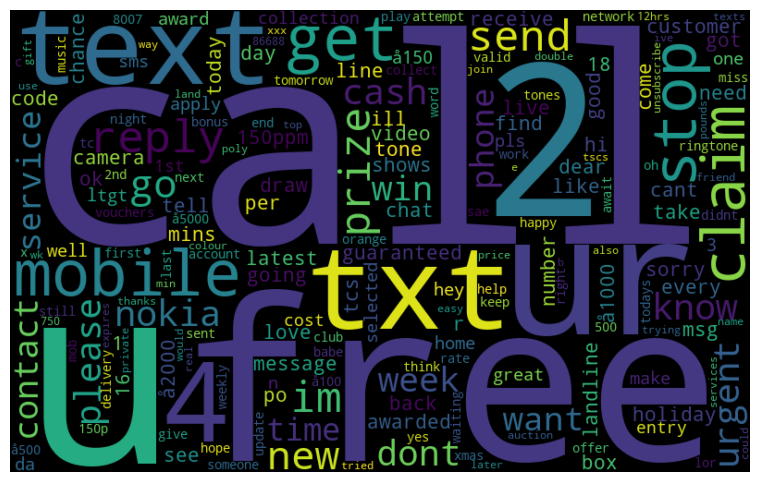

In [13]:
# Word Cloud
from collections import Counter
from wordcloud import WordCloud

all_text = ' '.join(data['Text'])
all_words = all_text.split()
word_fre = Counter(all_words)

# Word Cloud
wdcld = WordCloud(width = 800, height = 500).generate_from_frequencies(word_fre)
plt.figure(figsize=(10,6))
plt.imshow(wdcld, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [14]:
# Tokenization and Label Encoding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

texts = data['Text']
label = data['Type']

# Tokenization
token = Tokenizer()
token.fit_on_texts(texts)
seq = token.texts_to_sequences(texts)

# Padding sequences to have the same length
max_len = max(len(s) for s in seq)
X = pad_sequences(seq, maxlen=max_len)

# Label Encoding
# Encode labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(label)
Y = to_categorical(Y)

In [27]:
# Splitting the Dataset

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

### Model

In [28]:
# Building Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

input_size = len(token.word_index) + 1
output_size = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', verbose = 2)

model = Sequential([Embedding(input_dim = input_size, output_dim = output_size),
                    Bidirectional(LSTM(118, return_sequences=True)),
                    Dropout(0.25),
                    Bidirectional(LSTM(59)),
                    Dropout(0.35),
                    Dense(2, activation = 'softmax')])

In [29]:
# Compiling Model

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [30]:
# Training the model 

epochs = 10
batch_size = 32

mdl = model.fit(X_train, Y_train, epochs = epochs, callbacks = [early_stopping], batch_size = batch_size, validation_split = 0.2, verbose = 2)

Epoch 1/10
30/30 - 4s - 149ms/step - accuracy: 0.7762 - loss: 0.4605 - val_accuracy: 0.8870 - val_loss: 0.2615
Epoch 2/10
30/30 - 1s - 32ms/step - accuracy: 0.9592 - loss: 0.1341 - val_accuracy: 0.9582 - val_loss: 0.1408
Epoch 3/10
30/30 - 1s - 32ms/step - accuracy: 0.9916 - loss: 0.0300 - val_accuracy: 0.9665 - val_loss: 0.1313
Epoch 4/10
30/30 - 1s - 32ms/step - accuracy: 0.9969 - loss: 0.0113 - val_accuracy: 0.9665 - val_loss: 0.1723
Epoch 4: early stopping


In [31]:
# Summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 72, 100)        │       470,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 72, 236)        │       206,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 236)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 118)            │       139,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           238 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,451,260 (9.35 MB)

 Trainable params: 817,086 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,634,174 (6.23 MB)

In [32]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f"Loss : {loss*100}\nAccuracy : {accuracy*100}")

10/10 - 0s - 10ms/step - accuracy: 0.9699 - loss: 0.1094
Loss : 10.936418175697327
Accuracy : 96.98996543884277


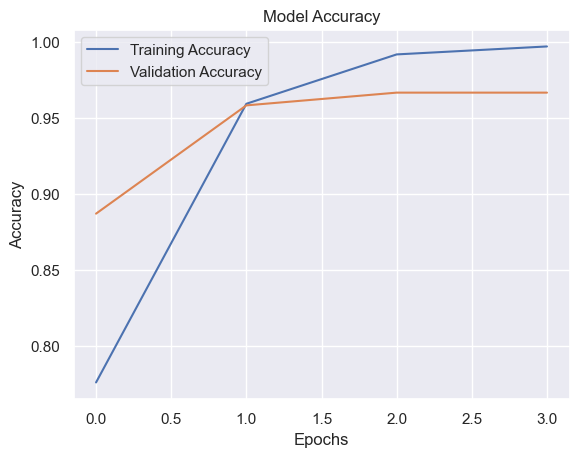

In [33]:
# Model Accuracy

plt.plot(mdl.history['accuracy'], label='Training Accuracy')
plt.plot(mdl.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


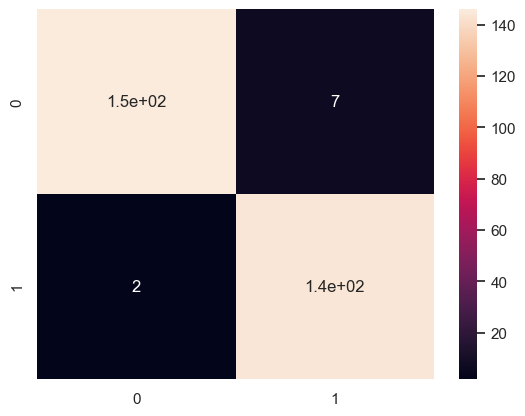

In [34]:
from sklearn.metrics import confusion_matrix

# Classification report
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Confusion matrix
sns.heatmap(confusion_matrix(Y_true, Y_pred_classes), annot=True)
plt.show()

In [35]:
# Prediction function

def predict(text):

    text = clean_text(text)
    sequence = token.texts_to_sequences(text)
    pad_seq = pad_sequences(sequence, maxlen=max_len)

    pred = model.predict(pad_seq)

    label_pred = label_encoder.inverse_transform([pred.argmax(axis=1)[0]])
    return label_pred[0]

##### 1: Ham 0: Spam

In [36]:
# Testing Prediction Function

print(predict("Please attend the meeting at 10 AM tomorrow."))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1
